# Imports

In [1]:
#!pip install -r requirements.txt

In [24]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pickle

import pprint
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

from src.bayesian_network import BayesianNetwork

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
fig_mode = 'png' # svg for interactive plots

# 0. Description

In this notebook, we use the causal relationships found in NLTK's Reuters corpus to create a DAG (causal network, Bayesian network) to model causal relationships between macroeconomic concepts.

We test the effect of some hyperparameters and finally show a use case of this Bayesian network. 

# 1. Loading Data

In [26]:
data = pickle.load(open( "data/data_reuters.p", "rb" ))
data.date = pd.to_datetime(data.date, utc=True)

In [27]:
data

,date,sentence,cause,effect,directions
0,2021-01-01 00:00:00+00:00,Commodities from gold to grains to cotton post...,dollar,inflation,"(1, 1)"
1,2021-01-01 00:00:00+00:00,Fed officials have long expressed concern that...,dollar,inflation,"(0, 1)"
2,2021-01-01 00:00:00+00:00,The OECD said that the [E1]dollar[/E1] fall ha...,dollar,inflation,"(0, 1)"
3,2021-01-01 00:00:00+00:00,They said the Fed is reluctant to lower short ...,dollar,inflation,"(0, 1)"
4,2021-01-01 00:00:00+00:00,Most economists predict growth slower than the...,dollar,inflation,"(0, 1)"
...,...,...,...,...,...
69,2021-01-01 00:00:00+00:00,The study cited two basic policy paths for the...,oil,import,"(1, 0)"
70,2021-01-01 00:00:00+00:00,But this rise was due entirely to the lower va...,oil,import,"(1, 0)"
71,2021-01-01 00:00:00+00:00,They say it would not only curb the growth of ...,import,oil,"(1, 1)"
72,2021-01-01 00:00:00+00:00,Yergin said he saw mounting support within Con...,import,oil,"(1, 1)"


In [28]:
data.date.min(), data.date.max()

(Timestamp('2021-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2021-01-01 00:00:00+0000', tz='UTC'))

Each row reprsents a causal relationship between two concepts.

In the example : 

**cause 	effect 	directions        :         dollar 	inflation 	(1, 1)**

The cause is the **dollar rising (1)** and the effect is the **inflation rising (1)**

# 2. Bayesian Network

To fit the bayesian network, we minimize the following loss function :

$$
L(\theta, \gamma)=\sum_{s=1}^{S}\left(p_{s}-\left[M \frac{e^{\mathrm{X} \theta}}{\sum e^{\mathrm{X\theta}}}\right]_{s}\right)^{2}+\sum_{r=1}^{2^{\nu}}\left(\left[\frac{e^{\mathrm{X} \theta}}{\sum e^{\mathrm{X\theta}}}\right]_{r}-\left[e^{A \ln \left(\gamma^{\prime}\right)}\right]_{r}\right)^{2} \text { , }
$$

and the resulting JPT is 

$$
J P T^{B N}=e^{A \ln \left(\gamma^{\prime}\right)}
$$

Details of the calculations : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3808233

In [29]:
graph = BayesianNetwork(random_state=42)

In [30]:
threshold = 3 ## minimum number of occurences to define a relation

date_start = '2021-01-01'
date_end = '2021-01-01'

graph.fit(data, threshold, date_start, date_end)

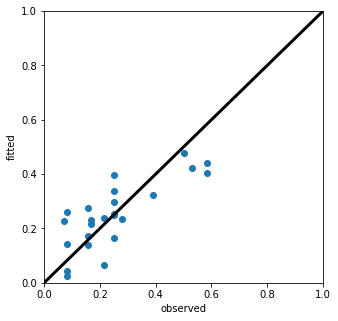

[   ('dollar', 'inflation', {'odds_ratio': 0.20371472429505508}),
    ('dollar', 'export', {'odds_ratio': 0.89392890183784}),
    ('export', 'oil', {'odds_ratio': 51.44807084292245}),
    ('oil', 'inflation', {'odds_ratio': 1.4804781578649175}),
    ('oil', 'import', {'odds_ratio': 0.12787061597293958}),
    ('import', 'inflation', {'odds_ratio': 8.168167024218848})]


In [31]:
## Observed edge probabilities (x-axis) vs. the fitted probabilities (y-axis) 

graph.plot_fitted_edge_proba()

In [32]:
graph.plot()

:Overlay
   .Graph.I  :Graph   [start,end]   (odds_ratio,edge_line_width)
   .Labels.I :Labels   [x,y]   (index)

# 3. Threshold effect

Here, we test the effect of the minimun number of occurences needed to define a causal relationship.

In [11]:
thresholds=[2,3,5,8]

date_start='2021-01-01'
date_end='2021-01-01'

odds_mean_lst = []
n_edges_lst = []

for th in thresholds:
    graph = BayesianNetwork(random_state=42)
    graph.fit(data, th, date_start, date_end)
    
    odds_mean_lst += [np.mean(list(graph.bn.odds.values()))]
    n_edges_lst += [len(graph.dag.edges)]

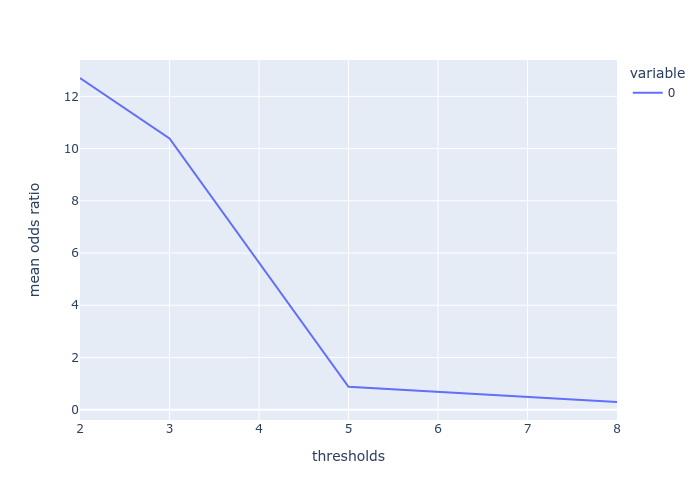

In [12]:
fig = pd.Series(odds_mean_lst,index=thresholds).plot()
fig.update_layout(xaxis_title='thresholds',
                      yaxis_title='mean odds ratio',)
fig.show(fig_mode)

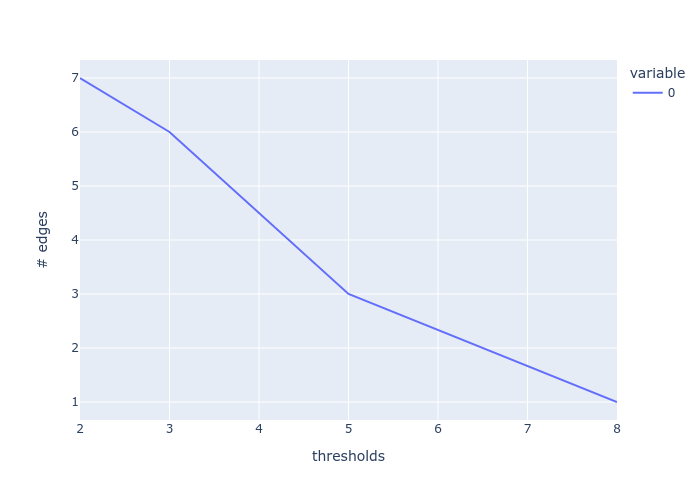

In [13]:
fig = pd.Series(n_edges_lst,index=thresholds).plot()
fig.update_layout(xaxis_title='thresholds',
                      yaxis_title='# edges',)
fig.show(fig_mode)

# 3. Inference - stress test

In this section, we vary the probabilities of the root nodes and observe the results on the probabilities of the target node.

## Case 1 : one root node

In [14]:
threshold = 3

date_start='2021-01-01'
date_end='2021-01-01'

graph = BayesianNetwork(random_state=42)
graph.fit(data, threshold, date_start, date_end)
graph.plot()

:Overlay
   .Graph.I  :Graph   [start,end]   (odds_ratio,edge_line_width)
   .Labels.I :Labels   [x,y]   (index)

In [15]:
graph.prior_format()

Nodes :
['dollar', 'inflation', 'export', 'oil', 'import']
[['1-dollar_proba_up', 'dollar_proba_up'], [0, 0], [0, 0], [0, 0], [0, 0]]


In [16]:
def inf_(dollar_proba_up):
    prior = np.array([[1-dollar_proba_up, dollar_proba_up], [0, 0], [0, 0], [0, 0], [0, 0]]) ## Prior of root nodes
    prediction = graph.predict(prior)
    return prediction['inflation']

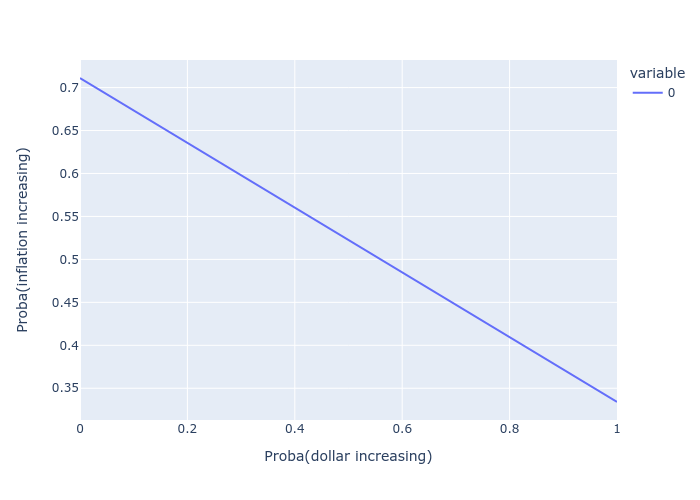

In [17]:
x = np.linspace(0, 1, 101)
fig = pd.Series(inf_(x),index=x).plot()
fig.update_layout(xaxis_title='Proba(dollar increasing)',
                      yaxis_title='Proba(inflation increasing)',)
fig.show(fig_mode)

## Case 2 : two root nodes

In [18]:
threshold = 5

date_start='2021-01-01'
date_end='2021-01-01'

graph = BayesianNetwork(random_state=42)
graph.fit(data, threshold, date_start, date_end)
graph.plot()

:Overlay
   .Graph.I  :Graph   [start,end]   (odds_ratio,edge_line_width)
   .Labels.I :Labels   [x,y]   (index)

In [19]:
graph.prior_format()

Nodes :
['dollar', 'inflation', 'export', 'oil']
[['1-dollar_proba_up', 'dollar_proba_up'], [0, 0], [0, 0], ['1-oil_proba_up', 'oil_proba_up']]


In [20]:
def inf_(dollar_proba_up, oil_proba_up):
    prior = np.array([[1-dollar_proba_up, dollar_proba_up], [0, 0], [0, 0], [1-oil_proba_up, oil_proba_up]]) ## Prior of root nodes
    prediction = graph.predict(prior)
    return prediction['inflation']

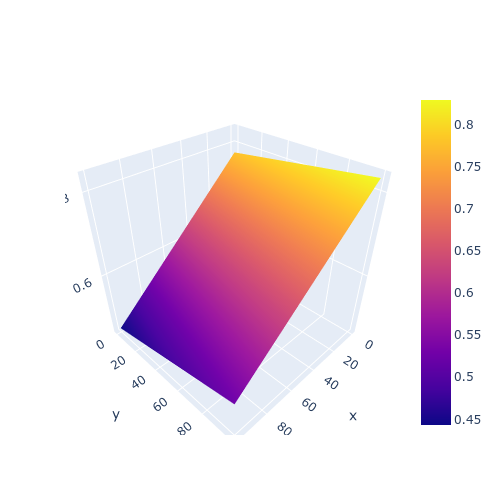

In [21]:
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)

X, Y = np.meshgrid(x, y)

Z = inf_(X, Y)

fig = go.Figure(data=[go.Surface(z=Z)])

fig.update_layout( autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show(fig_mode)